<div align="center">

# **Procesamiento Avanzado en Comunicaciones Digitales**
## **Trabajo Final - Estimación de ICI realizando extracción de características a través de cumulantes y algoritmos de clasificación**

**Valentina Restrepo - Julián Sánchez**

</div>


# **Delimitación y descripción del problema**

Estimación de la ICI/OSNR usando 3 algoritmos de aprendizaje supervisado diferentes (SVM, KNN, Random Forest), con 
diferentes estrategias para extracción de características:

- métricas estadísticas como cumulantes por cada cluster (16 clusters, 16QAM):
    - C21 (Potencia total de la señal)
    - C20 (Energía real para detectar desbalance I-Q)
    - M42
    - C42_img (Asimetrías de fase)
    - C63_real (Estructura fina de modulación)
    - C42_norm (Forma de la constenación)
    - Q_std (Dispersión Q)
    - IQ_corr (correlación I-Q)

Cada canal tiene **16 Gbaudios con roll-off de 0.1**, por lo que para un pulso con roll-off $\alpha$ y tasa de símbolos &R_s (Gbaud)&, el ancho de banda ocupado por canal es:


$BW_{ocupado} = R_s × (1 + \alpha)$

Y sustituyendo tendría:


$BW_{ocupado} = 16Gbaud × (1 + 0.1) = 16 × 1.1 = 17.6 GHz $

**Matriz de Características** Cada archivo .csv será un solo vector de 129 características por cada 10.000 símbolos.

$8$ features (cumulantes) $× 16$ clusters $= 128$ features para cada archivo .csv (70 archivos), por lo que la matriz tendría la forma:

$70$ filas $× 128 + 1$ (SNR) columnas

# **Librerías**

In [9]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN


# **Base de Datos y Split**

| carpeta | separation_GHz | occupied_bw_GHz | gap_GHz | label_by_occupied |
| ------: | :------------: | :-------------: | :-----: | :---------------: |
|   15GHz |      15.0      |       17.6      |   -2.6  |         0         |
| 15.5GHz |      15.5      |       17.6      |   -2.1  |         0         |
|   16GHz |      16.0      |       17.6      |   -1.6  |         0         |
| 16.5GHz |      16.5      |       17.6      |   -1.1  |         0         |
|   17GHz |      17.0      |       17.6      |   -0.6  |         0         |
| 17.6GHz |      17.6      |       17.6      |   0.0   |         1         |
|   18GHz |      18.0      |       17.6      |   +0.4  |         1         |


In [10]:

# 1. Rutas de carpetas
BASE_PATH = './database'

carpetas = {
    "15GHz": 1,
    "15p5GHz": 1,
    "16GHz": 1,
    "16p5GHz": 1,
    "17GHz": 1,
    "17p6GHz": 0,   # sin ICI
    "18GHz": 0      # sin ICI
}

# Lista para guardar TODO
dataset = []

print("Cargando archivos :D")


# 2. Recorrer carpetas
for carpeta, etiqueta in carpetas.items():

    path = os.path.join(BASE_PATH, carpeta) # entro en cada carpeta
    archivos = sorted([f for f in os.listdir(path) if f.endswith('.csv')]) # se filtran y ordenan los archivos terminados en .csv

    print(f"\n Carpeta: {carpeta}  |  Etiqueta ICI={etiqueta}  |  {len(archivos)} archivos") # cantidad de .csv en esa carpetica

    for archivo in archivos: # se recorre cada archivo .csv detectado
        file_path = os.path.join(path, archivo)

        # Cargar datos I/Q
        df = pd.read_csv(file_path)

        # Validar mínimo requerido
        if not {"I", "Q"}.issubset(df.columns):
            raise ValueError(f"El archivo {archivo} no tiene columnas I y Q.")

        # Guardar estructura
        dataset.append({
            "carpeta": carpeta,
            "archivo": archivo,
            "etiqueta": etiqueta,
            "data": df[["I", "Q"]]
        })

print("\nDatos cargados correctamente")


# 3. Split por archivo (NO mezclamos símbolos)
train_files, test_files = train_test_split(
    dataset,
    test_size=0.2, # 20% de los archivos totales serán test
    shuffle=True, # mezclar los archivos para evitar sesgos

    # Con stratify aseguro que se mantenga la proporción de clases (0,1) en ambos conjuntos
    # de train y test.
    stratify=[d["etiqueta"] for d in dataset]  # estratificación por ICI
)

print(f"\nArchivos para TRAIN: {len(train_files)}")
print(f"Archivos para TEST:  {len(test_files)}")



Cargando archivos :D

 Carpeta: 15GHz  |  Etiqueta ICI=1  |  7 archivos

 Carpeta: 15p5GHz  |  Etiqueta ICI=1  |  9 archivos

 Carpeta: 16GHz  |  Etiqueta ICI=1  |  11 archivos

 Carpeta: 16p5GHz  |  Etiqueta ICI=1  |  11 archivos

 Carpeta: 17GHz  |  Etiqueta ICI=1  |  11 archivos

 Carpeta: 17p6GHz  |  Etiqueta ICI=0  |  11 archivos

 Carpeta: 18GHz  |  Etiqueta ICI=0  |  10 archivos

Datos cargados correctamente

Archivos para TRAIN: 56
Archivos para TEST:  14


Cada archivo .csv se carga como un DataFrame con columnas I,Q y se guarda así:

{
  "carpeta": "17GHz",
  "archivo": "snr_10.csv",
  "etiqueta": 1,
  "data": df[["I","Q"]]
}


Luego, se hace el split por archivo, para evitar que un mismo archivo termine en train y test (leakage y sesgos).

In [11]:
dataset_1 = dataset
dataframe = pd.DataFrame(dataset_1)

dataframe

,carpeta,archivo,etiqueta,data
0,15GHz,16QAM_3x16GBd_consY23dB.csv,1,I Q 0 2.356595 1...
1,15GHz,16QAM_3x16GBd_consY25dB.csv,1,I Q 0 2.576490 -3...
2,15GHz,16QAM_3x16GBd_consY27dB.csv,1,I Q 0 1.701967 2...
3,15GHz,16QAM_3x16GBd_consY30dB.csv,1,I Q 0 -3.075793 2...
4,15GHz,16QAM_3x16GBd_consY32dB.csv,1,I Q 0 3.042746 -3...
...,...,...,...,...
65,18GHz,16QAM_3x16GBd_consY27dB.csv,0,I Q 0 -0.956442 0...
66,18GHz,16QAM_3x16GBd_consY30dB.csv,0,I Q 0 -3.173633 1...
67,18GHz,16QAM_3x16GBd_consY32dB.csv,0,I Q 0 2.609396 -1...
68,18GHz,16QAM_3x16GBd_consY35dB.csv,0,I Q 0 2.918820 -3...


In [12]:
dataset_1 = dataset
dataframe = pd.DataFrame(dataset_1)

dataframe

,carpeta,archivo,etiqueta,data
0,15GHz,16QAM_3x16GBd_consY23dB.csv,1,I Q 0 2.356595 1...
1,15GHz,16QAM_3x16GBd_consY25dB.csv,1,I Q 0 2.576490 -3...
2,15GHz,16QAM_3x16GBd_consY27dB.csv,1,I Q 0 1.701967 2...
3,15GHz,16QAM_3x16GBd_consY30dB.csv,1,I Q 0 -3.075793 2...
4,15GHz,16QAM_3x16GBd_consY32dB.csv,1,I Q 0 3.042746 -3...
...,...,...,...,...
65,18GHz,16QAM_3x16GBd_consY27dB.csv,0,I Q 0 -0.956442 0...
66,18GHz,16QAM_3x16GBd_consY30dB.csv,0,I Q 0 -3.173633 1...
67,18GHz,16QAM_3x16GBd_consY32dB.csv,0,I Q 0 2.609396 -1...
68,18GHz,16QAM_3x16GBd_consY35dB.csv,0,I Q 0 2.918820 -3...


# **Concatenación del Dataset de Train**

Se tomará cada archivo de **train_files** y se extraerán sus columnas I/Q para concatenarlas en un gran array, esto con el fin de correr un solo **FCM global** que define los 16 clusters universales.

In [13]:
print("\nConstruyendo dataset de train global (56 archivos)")

# 1. Concatenar todos los puntos I/Q de los archivos de TRAIN (56 archivos)
iq_train_list = []

for item in train_files:
    data_iq = item["data"].values   # extraigo las columnas I y Q del dataset 
    iq_train_list.append(data_iq) # los concateno en la lista

# se convierte a un solo arreglo gigante
iq_train_global = np.vstack(iq_train_list)

print(f"Tamaño total TRAIN global: {iq_train_global.shape}")


Construyendo dataset de train global (56 archivos)
Tamaño total TRAIN global: (6096384, 2)


# **Extracción de Características**

## **Funciones para clusters**

In [14]:
# 1. Definir 16 puntos ideales 16QAM
def puntos_16QAM():

    # Niveles típicos de 16QAM (normalizados)
    niveles = [-3, -1, 1, 3] # 4 niveles en la parte I (in-phase) y en la parte Q (quadrature)

    puntos = []

    # doble for para generar todas las 16 combinacciones: puntos [I,Q]
    for i in niveles: 
        for q in niveles:
            puntos.append([i, q])
    return np.array(puntos)


# 2. Función para asignar cluster a cada símbolo medido (I,Q)
'''
Esta función recibe todos los símbolos medidos en los archivos .csv y los puntos ideales 
calculados en la función anterior. 

Para cada símbolo medido hace lo siguiente:
- Calcula la distancia euclidiana entre ese símbolo y cada punto ideal
- se encuentra el índice del punto ideal más cercano (cluster asignado)
- se guarda el índice de cluster en la lista clusters
'''
def asignar_clusters(iq_medidos, puntos_ideales):
    clusters = []
    for punto in iq_medidos:

        # Calcular distancias euclidianas a cada punto ideal
        distancias = np.linalg.norm(puntos_ideales - punto, axis=1)

        # Asignar cluster con distancia mínima
        cluster = np.argmin(distancias)
        clusters.append(cluster)
    return np.array(clusters)



## **Funciones para extracción de caracteristicas**     

In [15]:
def calcular_C21(iq_data):
    """ Potencia total de la señal
        C21 = E[x]^2 donde x = I + jQ
    """

    I = iq_data['I'].values
    Q = iq_data['Q'].values
    
    # Señal compleja
    x = I + 1j * Q
    
    # Potencia = E[|x|^2]
    potencia = np.mean(np.abs(x)**2)
    
    return potencia

def calcular_C20(iq_data):
    """
    Calcula C20: Energía real para detectar desbalance I-Q
    C20 = E[x^2] donde x = I + jQ
    Mide la asimetría entre componentes I y Q
    """
    I = iq_data['I'].values
    Q = iq_data['Q'].values
    
    # Señal compleja
    x = I + 1j * Q
    
    # C20 = E[x^2]
    C20 = np.mean(x**2)
    
    return np.real(C20)

def calcular_M42(iq_data):
    """
    Calcula M42: Momento estadístico de cuarto orden
    M42 = E[|x|^4] donde x = I + jQ
    Relacionado con la curtosis de la señal
    """
    I = iq_data['I'].values
    Q = iq_data['Q'].values
    
    # Señal compleja
    x = I + 1j * Q
    
    # M42 = E[|x|^4]
    M42 = np.mean(np.abs(x)**4)
    
    return M42

def calcular_C42_img(iq_data):
    """
    Calcula C42_img: Asimetrías de fase
    C42 = E[x^4] - 3*(E[|x|^2])^2
    Para señales complejas, la parte imaginaria detecta asimetrías de fase
    """
    I = iq_data['I'].values
    Q = iq_data['Q'].values
    
    # Señal compleja
    x = I + 1j * Q
    
    # C42 = E[x^4] - 3*(E[|x|^2])^2
    E_x4 = np.mean(x**4)
    E_abs_x2 = np.mean(np.abs(x)**2)
    
    C42 = E_x4 - 3 * (E_abs_x2)**2
    
    return np.imag(C42)

def calcular_C63_real(iq_data):
    """
    Calcula C63_real: Estructura fina de modulación
    C63 = E[|x|^6] - 9*E[|x|^4]*E[|x|^2] + 12*(E[|x|^2])^3
    Detecta características de orden superior de la modulación
    """
    I = iq_data['I'].values
    Q = iq_data['Q'].values
    
    # Señal compleja
    x = I + 1j * Q
    
    # Momentos necesarios
    E_abs_x2 = np.mean(np.abs(x)**2)
    E_abs_x4 = np.mean(np.abs(x)**4)
    E_abs_x6 = np.mean(np.abs(x)**6)
    
    # C63 = E[|x|^6] - 9*E[|x|^4]*E[|x|^2] + 12*(E[|x|^2])^3
    C63 = E_abs_x6 - 9 * E_abs_x4 * E_abs_x2 + 12 * (E_abs_x2)**3
    
    return np.real(C63)

def calcular_C42_norm(iq_data):
    """
    Calcula C42_norm: Forma de la constelación (normalizado)
    C42_norm = C42 / (E[|x|^2])^2
    Proporciona información sobre la forma independiente de la potencia
    """
    I = iq_data['I'].values
    Q = iq_data['Q'].values
    
    # Señal compleja
    x = I + 1j * Q
    
    # C42 sin normalizar
    E_x4 = np.mean(x**4)
    E_abs_x2 = np.mean(np.abs(x)**2)
    C42 = E_x4 - 3 * (E_abs_x2)**2
    
    # Normalización
    if E_abs_x2 != 0:
        C42_norm = C42 / (E_abs_x2)**2
    else:
        C42_norm = 0
    
    return np.abs(C42_norm)

def calcular_Q_std(iq_data):
    """
    Calcula Q_std: Dispersión del componente Q
    Desviación estándar del componente en cuadratura
    """
    Q = iq_data['Q'].values
    
    # Desviación estándar del componente Q
    Q_std = np.std(Q)
    
    return Q_std

def calcular_IQ_corr(iq_data):
    """
    Calcula IQ_corr: Correlación entre componentes I y Q
    Correlación Pearson entre I y Q
    """
    I = iq_data['I'].values
    Q = iq_data['Q'].values
    
    # Correlación entre I y Q
    if np.std(I) != 0 and np.std(Q) != 0:
        IQ_corr = np.corrcoef(I, Q)[0, 1]
    else:
        IQ_corr = 0
    
    return IQ_corr



# KNN

(Aqui iria lo que andas haciendo de knn para la detección de puntos ideales)

- necesitas obtener un p_ideales
- usar la función `asignar_clusters` cada 10 mil puntos

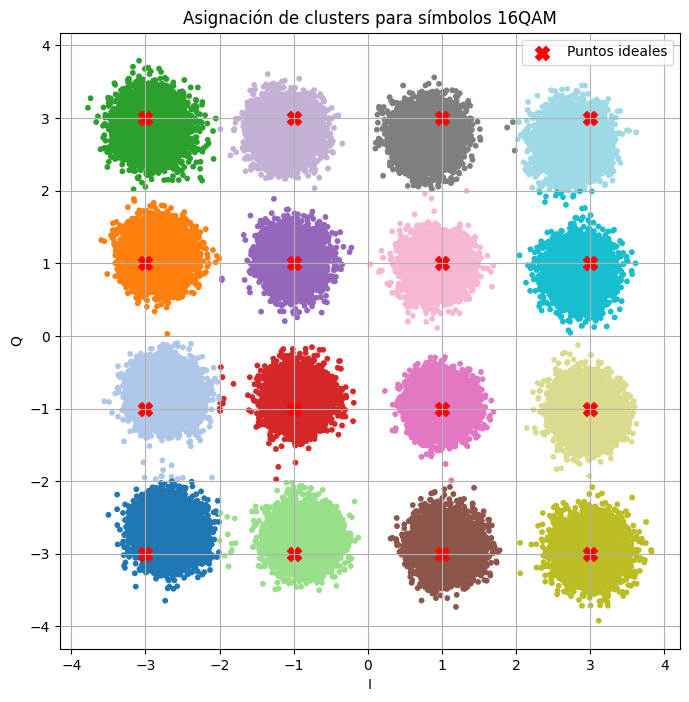

In [ ]:
# Ejemplo 


p_ideales = puntos_16QAM() # puntos ideales -----> Cambiar a los obtenidos por KNN

iq_medidos = df[['I', 'Q']].values # símbolos medidos (I,Q) que tomo del dataframe en el que guardé mis datos (último .csv)
clusters_asignados = asignar_clusters(iq_medidos, p_ideales)

# Visualización
plt.figure(figsize=(8,8))
plt.scatter(iq_medidos[:,0], iq_medidos[:,1], c=clusters_asignados, cmap='tab20', s=10)
plt.scatter(p_ideales[:,0], p_ideales[:,1], c='red', marker='X', s=100, label='Puntos ideales')
plt.title('Asignación de clusters para símbolos 16QAM')
plt.xlabel('I')
plt.ylabel('Q')
plt.grid(True)
plt.legend()
plt.show()

## **OBTENER LA MATRIZ DE CARACTERISTICAS**

In [22]:
num_clusters = len(p_ideales)
num_rows = iq_train_global.shape[0] / 10000 # Cada 10 mil simbolos

print(num_rows)


fila = []
vector = []


# Iteración que crea el vector de caracteristicas (La fila de la matriz)
for k in range(num_clusters):
    # puntos por constelación I guess
    pts = iq_medidos[clusters_asignados == k]

    if len(pts) == 0:
        fila.append([np.nan]*8)
        continue

    df_cluster = pd.DataFrame(pts, columns=['I', 'Q'])

    fila = [
        calcular_C21(df_cluster),
        calcular_C20(df_cluster),
        calcular_M42(df_cluster),
        calcular_C42_img(df_cluster),
        calcular_C63_real(df_cluster),
        calcular_C42_norm(df_cluster),
        calcular_Q_std(df_cluster),
        calcular_IQ_corr(df_cluster)
    ]

    vector.append(fila)

print(vector)




609.6384
[[np.float64(14.620987604917886), np.float64(-0.04872882104410006), np.float64(216.4321219806186), np.float64(-1.509299127920734), np.float64(12269.964054133154), np.float64(3.9864866707409994), np.float64(0.21767843663250372), np.float64(-0.022405868547635183)], [np.float64(8.257733116238173), np.float64(6.922400127140693), np.float64(69.54105435810503), np.float64(59.67534329863665), np.float64(2185.7555527057684), np.float64(2.7181362893610888), np.float64(0.21837621203906532), np.float64(-0.027370349443041828)], [np.float64(9.357458099643507), np.float64(6.720008293565338), np.float64(89.18571714323427), np.float64(-85.82770094024015), np.float64(3186.586118703857), np.float64(3.1097983706720016), np.float64(0.21225070832204934), np.float64(-0.026197734632263887)], [np.float64(16.934536064498385), np.float64(0.2730727768464608), np.float64(290.2895091602842), np.float64(-8.921703021111538), np.float64(19069.892918113772), np.float64(3.988897770662594), np.float64(0.2291186

In [18]:
print("Archivo usado:", archivo) # archivo del ejemplo

Archivo usado: 16QAM_3x16GBd_consY40dB.csv


In [19]:


# iq_medidos: matriz Nx2 ya cargada con columnas [I, Q]

# 1. Clustering para encontrar los símbolos
clustering = DBSCAN(eps=0.15, min_samples=20).fit(iq_medidos)
labels = clustering.labels_

# 2. Filtrar ruido (DBSCAN asigna -1 a puntos ruidosos)
puntos_validos = iq_medidos[labels != -1]
labels_validos = labels[labels != -1]

# 3. Calcular centroides por clúster
centroides = {}
for label in np.unique(labels_validos):
    centroides[label] = puntos_validos[labels_validos == label].mean(axis=0)

# 4. Calcular el ruido (distancia de cada punto a su centroide)
distancias = []
for label in np.unique(labels_validos):
    pts = puntos_validos[labels_validos == label]
    c = centroides[label]
    d = np.linalg.norm(pts - c, axis=1)  # distancia euclidiana
    distancias.append(d)

distancias = np.concatenate(distancias)

# 5. Ruido RMS
ruido_rms = np.sqrt(np.mean(distancias**2))

# 6. Fuerza de la señal: distancia promedio entre centroides
todos_centroides = np.array(list(centroides.values()))
dist_intercentros = []
for i in range(len(todos_centroides)):
    for j in range(i+1, len(todos_centroides)):
        dist_intercentros.append(np.linalg.norm(todos_centroides[i] - todos_centroides[j]))
dist_intercentros = np.array(dist_intercentros)

senal = dist_intercentros.mean()

# 7. SNR
snr = 20 * np.log10(senal / ruido_rms)

print("SNR estimado:", snr, "dB")


SNR estimado: 22.735200426653257 dB
